# Evaluation Metrics

## 4.1 Evaluation metrics

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv("data-week-3.csv")

df.columns = df.columns.str.lower().str.replace(' ',"_")

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ','_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors = 'coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train , df_test = train_test_split(df , test_size = 0.2 , random_state= 1)
df_train , df_val = train_test_split(df_full_train , test_size = 0.25 , random_state= 1)

df_train.reset_index(inplace= True , drop = True)
df_val.reset_index(inplace= True , drop = True)
df_test.reset_index(inplace= True , drop = True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse= False)

train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression()
model.fit(X_train,y_train)

LogisticRegression()

In [7]:
val_dicts = df_val[categorical + numerical].to_dict(orient = 'records')

X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred > 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model
- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [8]:
(y_val == churn_decision).mean()

0.8034066713981547

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds :
    score = accuracy_score(y_val,y_pred > t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


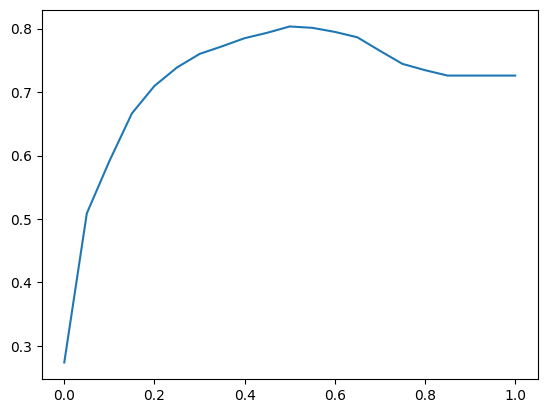

In [11]:
plt.plot(thresholds,scores)

In [12]:
from collections import Counter

In [13]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [14]:
1 - y_val.mean()

0.7260468417317246

## 4.3 Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

![](./image/4.3%20confusion%20table.JPG)

In [15]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [16]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [17]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [18]:
tp, tn, fp, fn

(210, 922, 101, 176)

![](./image/4.3%20confusion%20table2.JPG)

## 4.4 PRECISION & RECALL

PRECISION 
- HOW MANY FRACTION OF POSITIVE PREDICTIONS THAT ARE CORRECT

![](./image/4.4%20precisions.JPG)

In [20]:
p = tp / (tp + fp)
p

0.6752411575562701

RECALL
- HOW MANY FRACTION OF CORRECTLY IDENTIFIED POSITIVE EXAMPLES

![](./image/4.4%20recall.JPG)

In [21]:
r = tp / (tp + fn)
r

0.5440414507772021

![](./image/4.4%20Acc.JPG)

## 4.5 ROC Curves

*TPR and FRP*

In [22]:
tpr = tp / (tp + fn)
tpr

0.5440414507772021

In [23]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [24]:
thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    scores.append((t, tp, fp, fn, tn))

In [26]:
columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
df_score = pd.DataFrame(scores, columns = columns)

In [29]:
df_score['tpr'] = df_score.tp / (df_score.tp + df_score.fn)
df_score['fpr'] = df_score.fp / (df_score.fp + df_score.tn)

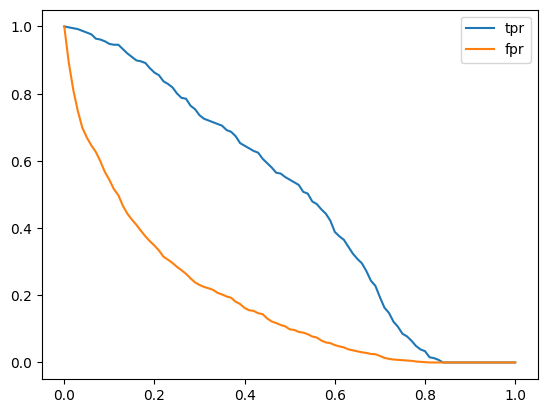

In [34]:
plt.plot(df_score.thresholds , df_score['tpr'] , label = 'tpr')
plt.plot(df_score.thresholds , df_score['fpr'] , label = 'fpr')
plt.legend()

**Random model**

In [36]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size = len(y_val))

In [37]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [44]:
def tpr_fpr_dataframe(y_val,y_pred):
    thresholds = np.linspace(0, 1, 101)

    scores = []

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        
        scores.append((t, tp, fp, fn, tn))
    
    columns = ['thresholds', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns = columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [45]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

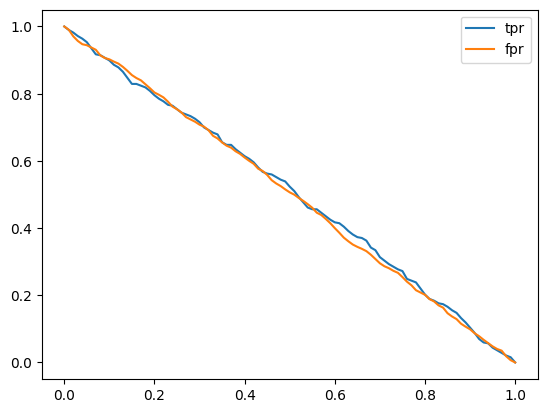

In [46]:
plt.plot(df_rand.thresholds , df_rand['tpr'] , label = 'tpr')
plt.plot(df_rand.thresholds , df_rand['fpr'] , label = 'fpr')
plt.legend()

**Ideal model**

In [47]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [49]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [51]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [53]:
1 - y_val.mean()

0.7260468417317246

In [55]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [56]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

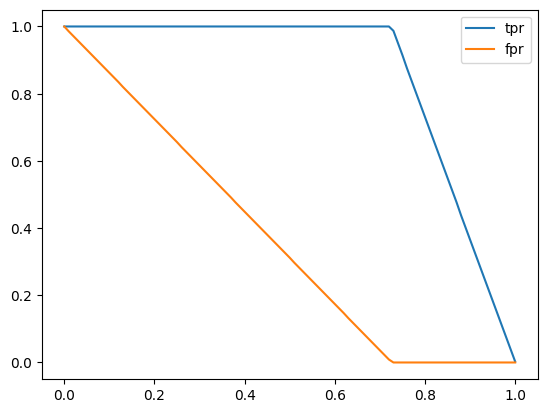

In [57]:
plt.plot(df_ideal.thresholds , df_ideal['tpr'] , label = 'tpr')
plt.plot(df_ideal.thresholds , df_ideal['fpr'] , label = 'fpr')
plt.legend()

**Putting everthing together**

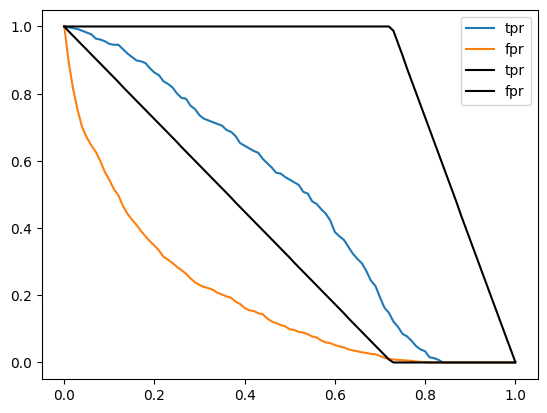

In [59]:
plt.plot(df_score.thresholds , df_score['tpr'] , label = 'tpr')
plt.plot(df_score.thresholds , df_score['fpr'] , label = 'fpr')

# plt.plot(df_rand.thresholds , df_rand['tpr'] , label = 'tpr')
# plt.plot(df_rand.thresholds , df_rand['fpr'] , label = 'fpr')

plt.plot(df_ideal.thresholds , df_ideal['tpr'] , label = 'tpr', color = 'black')
plt.plot(df_ideal.thresholds , df_ideal['fpr'] , label = 'fpr', color = 'black')

plt.legend()

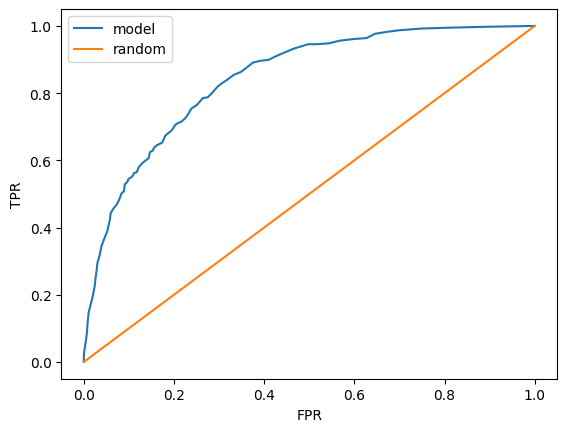

In [66]:
plt.plot(df_score.fpr, df_score.tpr, label ='model')
plt.plot([0, 1], [0, 1], label ='random')
# plt.plot(df_rand.fpr, df_rand.tpr, label ='random')
# plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

## 4.5 ROC Curves

In [67]:
from sklearn.metrics import roc_curve

In [68]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

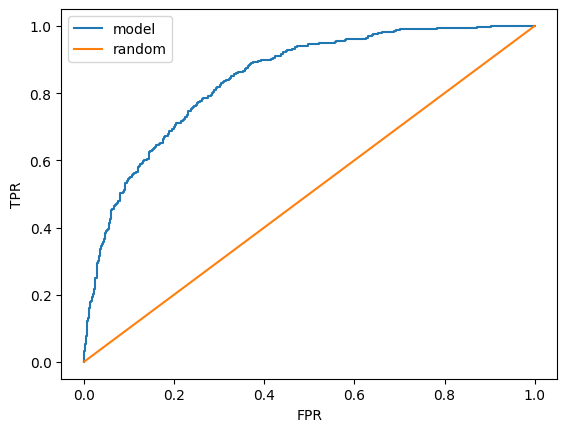

In [71]:
plt.plot(fpr, tpr, label ='model')
plt.plot([0, 1], [0, 1], label ='random')
# plt.plot(df_rand.fpr, df_rand.tpr, label ='random')
# plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel("FPR")
plt.ylabel("TPR")

plt.legend()

## 4.6 ROC AUC